### Stacking Ensemble - Blending
Assuming we have $n$ models and the reconstructed matrix by the
$i$-th model is denoted by $\hat{A}$, the final prediction would be
$$\hat{A} = w_0 + \sum_{i=1}^{n}w_i \hat{A}^i$$

$\hat{A}^i$ fixed, only learn $w_i$ for $i = 0, 1, ..., n$

We split the data into training and holdout set (say 95% - 5%, or try different split ratios). The level-0 $n$ models are trained on the training set. The weights $w_i$ of the level-1 ensemble model are then learned on the holdout set.

In [1]:
# model-1: SVP - 10 instances k=1,3,5,..19
# model-2: Regularized SVD - 10 instances
# model-3: SVT - 10 instances
import numpy as np
import pandas as pd
n = 3 # number of models
data = pd.read_csv("./data/data_train.csv")
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Id,Prediction
0,r6010_c988,4
1,r3909_c747,5
2,r3440_c617,5
3,r2429_c527,3
4,r3797_c230,5


In [2]:
users, movies = \
        [np.squeeze(arr) for arr in \
        np.split(data.Id.str.extract("r(\d+)_c(\d+)").values.astype(int) - 1, 2, axis=-1)]
predictions = data.Prediction.values
predictions = predictions.astype('float')

In [3]:
train_size = int(0.97 * users.shape[0])
A = np.full((10000, 1000), 0)
for user , movie , pred in zip(users[:train_size], movies[:train_size], predictions[:train_size]):
    A[user][movie] = pred
W = (A > 0).astype(int)
import utils
norm_A, mean_A, stddev_A = utils.zscore_masked_items(A, W)

In [4]:
sample_pd = pd.read_csv("./data/sampleSubmission.csv")
test_users, test_movies = \
    [np.squeeze(arr) for arr in \
    np.split(sample_pd.Id.str.extract("r(\d+)_c(\d+)").values.astype(int) - 1, 2, axis=-1)]

In [5]:
## Ensemble
## Assume rec_A is given
y_val = predictions[train_size:] #target of the ensemble
X_ensemble = np.ones((1, y_val.shape[0]))
raw_preds = np.empty((test_users.shape[0], 30),dtype=float)
model_n = 0
from SVP import SVP
rank_schedule = [1,3,5,7,9,11,15,20,25,30]
for k in range(10):
    model = SVP(A, K=rank_schedule[k])
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

from SVT import SVT
#eta, tau, epochs
schedule = [(1.2,2000,25), (1.5,2000,25), (1.2,1000,15), (1.2,1000,10),
(2.0,2000,25), (2.0,1000,15), (2.5,3000,10), (3.0,3000,10), (3.5,2000,15), (3.5,1000,25)]

for k in range(1):
    eta, tau, epochs = schedule[k]
    model = SVT(A, eta, tau, epochs)
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

from RSVD import RSVD
features_schedule = [50,100,150,200,250,300,324,350,400,450]
for k in range(6,7):
    features = features_schedule[k]
    model = RSVD(A, features=features)
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

print(X_ensemble.shape)
X_ensemble = X_ensemble.T


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


{'train_rmse': [1.0049351361851364, 1.03661832249369, 1.1145133457491967, 1.107512651016955, 0.9775812117833881, 0.9755824416199274, 0.97490445103586, 0.9746648203519055, 0.9745821302672445, 0.9745547983845283], 'test_rmse': []}


100%|██████████| 25/25 [02:27<00:00,  5.89s/it]


{'train_rmse': [1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.0293152751519885, 1.013434075234619, 1.0047726728740545, 1.001334447595028, 0.9997147084734773, 0.9987523220790174, 0.9980475962581288, 0.9974578204833733, 0.9950080637884416, 0.9896549764479328, 0.9822321405688885, 0.9789033400747009, 0.9759624195157552, 0.9704953373836582, 0.9639248451902666], 'test_rmse': []}


100%|██████████| 15/15 [04:51<00:00, 19.46s/it]

{'train_rmse': [1.0273487923398452, 1.013883978000307, 1.0107507609944884, 1.008996555662158, 1.0071504965911506, 1.0044948854959956, 0.9998254032804759, 0.9913380029920877, 0.9814470632405422, 0.9679630034394844, 0.9526074035095645, 0.9312504931284349, 0.905896474582688, 0.8740037203050934, 0.8378992687507257], 'test_rmse': []}
(4, 58848)


In [6]:
print(X_ensemble.shape, y_val.shape)
b, _, _, _ = np.linalg.lstsq(X_ensemble, y_val)
#final_preds = b[0][1:] * raw_preds
print(b)

(58848, 4) (58848,)
[0.00413882 0.15648688 0.35769276 0.48497873]


/tmp/ipykernel_46655/953104046.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, _, _, _ = np.linalg.lstsq(X_ensemble, y_val)


In [7]:
final_preds = np.sum(raw_preds * b[1:], axis=1) + b[0]
final_preds
#final_preds = b[1:] * raw_preds
#final_preds.shape[]

array([3.30322554, 3.13840517, 3.75757494, ..., 2.96213465, 3.28941731,
       3.78084752])

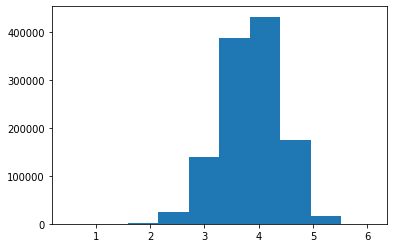

In [8]:
import matplotlib.pyplot as plt
plt.hist(final_preds)
plt.show()

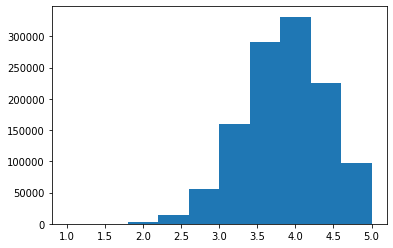

In [9]:
fps = np.copy(final_preds)
fps[fps > 5] = 5
fps[fps < 1] = 1
plt.hist(fps)
plt.show()

In [10]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
with open("./data/submissions/" + "ensemble_svp_svt_rsvd" + "_" + timestamp + ".csv", "w") as f:
    f.write("Id,Prediction\n")
    for (user, movie, pred) in zip(test_users, test_movies, fps):
        f.write("r{}_c{},{}\n".format(user + 1, movie + 1, pred))